In [1]:
#Подружаем необходимые пакеты
import pickle
import numpy as np
import pandas as pd
import torch
import random
from skimage import io
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision import models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision

from matplotlib import colors, pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip

--2020-06-21 15:27:20--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  21.2MB/s    in 4.5s    

2020-06-21 15:27:25 (16.5 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]



In [4]:
!unzip -q apple2orange.zip -d all

In [5]:
def get_same_index(target, label):
    label_indices = []

    for i in range(len(target)):
        if target[i] == label:
            label_indices.append(i)

    return label_indices

In [7]:
batch_size = 16
batchSize = 64
imageSize = 64


transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



data_path = 'all/apple2orange/'
train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

# Get indices of label_class
train_indices_A = get_same_index(train_dataset.targets, 3)[:960]

# Data loader
train_loader_A = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices_A))

# Get indices of label_class
train_indices_B = get_same_index(train_dataset.targets, 2)[:960]

# Data loader
train_loader_B = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices_B))

In [9]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 4, 0),
            *convlayer(32, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 64, 4, 2, 1, bn=True),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


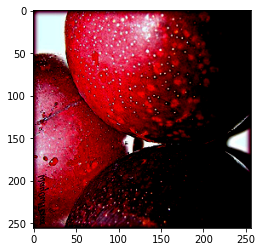

In [10]:
plt.imshow(train_dataset[50][0].numpy().transpose(2,1,0))

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), padding = 1 )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)   # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size =(3,3), padding =1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding = 2, dilation=2)
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2)# 64 -> 32
        self.enc_conv3 =nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = (3,3), padding = 2, dilation=2)
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2)# 32 -> 16

        # bottleneck
        self.bottleneck_conv  =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=2, dilation=2)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=2, dilation=2)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=2, dilation=2)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)

        self.dec_conv4 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder

        e0 = self.pool0((F.relu(self.enc_conv0(x))))
        e1 = self.pool1((F.relu(self.enc_conv1(e0))))
        e2 = self.pool2((F.relu(self.enc_conv2(e1))))
        e3 =self.pool3((F.relu(self.enc_conv3(e2))))
        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 =  F.relu(self.dec_conv0(self.upsample0(b)))
        d1 =  F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 =  F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 =  F.relu(self.dec_conv3(self.upsample3(d2)))
        d4 =  self.dec_conv4(d3)
        return d4

In [12]:
DEVICE = torch.device("cuda")
lr = 0.001
EPOCH = 10

In [13]:
netG_A2B = Generator()
netG_B2A = Generator()
netD_A = Discriminator()
netD_B = Discriminator()

netG_A2B = netG_A2B.to(DEVICE)
netG_B2A = netG_B2A.to(DEVICE)
netD_A = netD_A.to(DEVICE)
netD_B = netD_B.to(DEVICE)

netG_A2B_optimizer = torch.optim.Adam(params=netG_A2B.parameters(), lr=lr,betas=(0.5, 0.999))
netG_B2A_optimizer = torch.optim.Adam(params=netG_B2A.parameters(), lr=lr,betas=(0.5, 0.999))
netD_A_optimizer = torch.optim.Adam(params=netD_A.parameters(), lr=lr,betas=(0.5, 0.999))
netD_B_optimizer = torch.optim.Adam(params=netD_B.parameters(), lr=lr,betas=(0.5, 0.999))

optimizers = dict()
optimizers['G1'] = netG_A2B_optimizer
optimizers['G2'] = netG_B2A_optimizer
optimizers['D1'] = netD_A_optimizer
optimizers['D2'] = netD_B_optimizer

In [35]:
for epoch in tqdm(range(EPOCH)):
    train_loader_A_1 = iter(train_loader_A)
    for batchB in train_loader_B:
        batchA = next(train_loader_A_1)
        inputA = batchA[0].to(DEVICE)
        inputB = batchB[0].to(DEVICE)


        target_real = torch.ones(batch_size).view(-1).long().to(DEVICE)
        target_fake = torch.zeros(batch_size).view(-1).long().to(DEVICE)
        G_criterion = nn.L1Loss()
        D_criterion = nn.CrossEntropyLoss()

        optimizer_G1 = optimizers['G1']
        optimizer_G2 = optimizers['G2']
        optimizer_D1 = optimizers['D1']
        optimizer_D2 = optimizers['D2']

        optimizer_G1.zero_grad()
        optimizer_G2.zero_grad()


        ###### Generators A2B and B2A ######
        optimizer_G1.zero_grad()
        optimizer_G2.zero_grad()

        # Identity loss

        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(inputB)
        loss_identity_B = G_criterion(same_B, inputB) * 5
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(inputA)
        loss_identity_A = G_criterion(same_A, inputA) * 5


        # GAN loss

        fake_B = netG_A2B(inputA)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = D_criterion(pred_fake, target_real)

        fake_A = netG_B2A(inputB)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = D_criterion(pred_fake, target_real)

        # Cycle loss

        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = G_criterion(recovered_A, inputA) * 10

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = G_criterion(recovered_B, inputB) * 10

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB

        loss_G.backward()

        optimizer_G1.step()
        optimizer_G2.step()



        ###### Discriminator A ######

        optimizer_D1.zero_grad()

        # Real loss
        pred_real = netD_A(inputA)
        loss_D_real = D_criterion(pred_real, target_real)

        # Fake loss
        #fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = D_criterion(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()


        optimizer_D1.step()
        ###################################

        ###### Discriminator B ######

        optimizer_D2.zero_grad()

        # Real loss
        pred_real = netD_B(inputB)
        loss_D_real = D_criterion(pred_real, target_real)

        # Fake loss
        #fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = D_criterion(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()

        optimizer_D2.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, 1, batch_size, loss_D_A.item(), loss_G.item()))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[0/10][1/16] Loss_D: 0.0000; Loss_G: 5.1167
[0/10][1/16] Loss_D: 0.0000; Loss_G: 5.5338
[0/10][1/16] Loss_D: 0.0000; Loss_G: 4.9975
[0/10][1/16] Loss_D: -0.0008; Loss_G: 2.3964
[0/10][1/16] Loss_D: 0.0000; Loss_G: 5.3616
[0/10][1/16] Loss_D: -0.0008; Loss_G: -47.2485
[0/10][1/16] Loss_D: 0.0005; Loss_G: 5.4922
[0/10][1/16] Loss_D: 0.0006; Loss_G: 4.8792
[0/10][1/16] Loss_D: -0.1017; Loss_G: 4.6404
[0/10][1/16] Loss_D: -0.9914; Loss_G: 5.2372
[0/10][1/16] Loss_D: -0.0020; Loss_G: 5.1680
[0/10][1/16] Loss_D: 0.0012; Loss_G: 5.3318
[0/10][1/16] Loss_D: -0.0929; Loss_G: 5.0509
[0/10][1/16] Loss_D: 0.0000; Loss_G: 2.6233
[0/10][1/16] Loss_D: 0.0010; Loss_G: 5.1971
[0/10][1/16] Loss_D: 0.0000; Loss_G: 5.3581
[0/10][1/16] Loss_D: 0.0228; Loss_G: 6.8484
[0/10][1/16] Loss_D: 0.0000; Loss_G: 7.3781
[0/10][1/16] Loss_D: -0.0011; Loss_G: 6.5315
[0/10][1/16] Loss_D: -0.0020; Loss_G: 6.4456
[0/10][1/16] Loss_D: 0.0000; Loss_G: 6.3172
[0/10][1/16] Loss_D: -0.0008; Loss_G: 6.4285
[0/10][1/16] Loss_D: 

 10%|█         | 1/10 [01:39<14:59, 100.00s/it]

[0/10][1/16] Loss_D: 0.0000; Loss_G: 5.6186
[1/10][1/16] Loss_D: 0.0000; Loss_G: 5.0830
[1/10][1/16] Loss_D: -0.0000; Loss_G: 4.2908
[1/10][1/16] Loss_D: 0.0000; Loss_G: 4.5034
[1/10][1/16] Loss_D: 0.0009; Loss_G: 5.1075
[1/10][1/16] Loss_D: -1.1195; Loss_G: 3.1926
[1/10][1/16] Loss_D: 0.0000; Loss_G: 4.2480
[1/10][1/16] Loss_D: -0.0000; Loss_G: 5.4576
[1/10][1/16] Loss_D: -0.0000; Loss_G: 5.7892
[1/10][1/16] Loss_D: -0.0941; Loss_G: 5.3695
[1/10][1/16] Loss_D: -0.0009; Loss_G: 3.7626
[1/10][1/16] Loss_D: -0.0008; Loss_G: 5.6668
[1/10][1/16] Loss_D: 0.0000; Loss_G: 5.9826
[1/10][1/16] Loss_D: 0.0000; Loss_G: 2.8343
[1/10][1/16] Loss_D: -0.0014; Loss_G: 4.9331
[1/10][1/16] Loss_D: 0.0000; Loss_G: 4.7898
[1/10][1/16] Loss_D: -0.0008; Loss_G: 5.3310
[1/10][1/16] Loss_D: -0.0000; Loss_G: 2.7269
[1/10][1/16] Loss_D: 0.0288; Loss_G: 5.0748
[1/10][1/16] Loss_D: -0.0042; Loss_G: 5.8857
[1/10][1/16] Loss_D: -0.0062; Loss_G: 6.6520
[1/10][1/16] Loss_D: 0.0000; Loss_G: 6.1485
[1/10][1/16] Loss_D:

 20%|██        | 2/10 [03:19<13:19, 99.99s/it] 

[1/10][1/16] Loss_D: -0.0008; Loss_G: 4.2052
[2/10][1/16] Loss_D: 0.0000; Loss_G: 5.1076
[2/10][1/16] Loss_D: -1.2491; Loss_G: 4.4795
[2/10][1/16] Loss_D: -0.0000; Loss_G: 5.2082
[2/10][1/16] Loss_D: -0.0012; Loss_G: 4.9163
[2/10][1/16] Loss_D: -0.0035; Loss_G: 5.0971
[2/10][1/16] Loss_D: 0.0000; Loss_G: -97.5063
[2/10][1/16] Loss_D: 0.0000; Loss_G: 5.7909
[2/10][1/16] Loss_D: -0.0008; Loss_G: 5.2188
[2/10][1/16] Loss_D: 0.0000; Loss_G: 5.5700
[2/10][1/16] Loss_D: -0.0965; Loss_G: 4.9347
[2/10][1/16] Loss_D: -0.0008; Loss_G: 4.8668
[2/10][1/16] Loss_D: 0.0000; Loss_G: 5.6126
[2/10][1/16] Loss_D: 0.0000; Loss_G: 2.6708
[2/10][1/16] Loss_D: -0.0150; Loss_G: 5.6429
[2/10][1/16] Loss_D: 0.0000; Loss_G: 5.4563
[2/10][1/16] Loss_D: 0.0000; Loss_G: 5.9431
[2/10][1/16] Loss_D: 0.0000; Loss_G: 5.5877
[2/10][1/16] Loss_D: 0.0000; Loss_G: 2.9723
[2/10][1/16] Loss_D: -0.0008; Loss_G: 5.0087
[2/10][1/16] Loss_D: 0.0000; Loss_G: 3.2163
[2/10][1/16] Loss_D: 0.0000; Loss_G: 3.0631
[2/10][1/16] Loss_D:

 30%|███       | 3/10 [04:59<11:39, 100.00s/it]

[2/10][1/16] Loss_D: -0.0000; Loss_G: 5.4179
[3/10][1/16] Loss_D: -0.0008; Loss_G: 5.3779
[3/10][1/16] Loss_D: -0.0009; Loss_G: 4.3208
[3/10][1/16] Loss_D: 0.0000; Loss_G: 4.9412
[3/10][1/16] Loss_D: -0.0000; Loss_G: 2.3032
[3/10][1/16] Loss_D: 0.0000; Loss_G: 4.8507
[3/10][1/16] Loss_D: -0.0009; Loss_G: -55.3602
[3/10][1/16] Loss_D: 0.0000; Loss_G: 5.3672
[3/10][1/16] Loss_D: 0.0000; Loss_G: 5.6265
[3/10][1/16] Loss_D: 0.0000; Loss_G: 5.1809
[3/10][1/16] Loss_D: 0.0000; Loss_G: 5.1882
[3/10][1/16] Loss_D: 0.0000; Loss_G: 5.2338
[3/10][1/16] Loss_D: 0.0000; Loss_G: 2.7448
[3/10][1/16] Loss_D: 0.0000; Loss_G: 4.7026
[3/10][1/16] Loss_D: -0.0000; Loss_G: 4.4389
[3/10][1/16] Loss_D: -0.0008; Loss_G: 5.2291
[3/10][1/16] Loss_D: -0.0039; Loss_G: 3.9633
[3/10][1/16] Loss_D: 0.0000; Loss_G: -79.9242
[3/10][1/16] Loss_D: -0.0000; Loss_G: -89.5379
[3/10][1/16] Loss_D: 0.0000; Loss_G: 5.2737
[3/10][1/16] Loss_D: -0.0006; Loss_G: 2.5127
[3/10][1/16] Loss_D: 0.0000; Loss_G: 4.7010
[3/10][1/16] Los

 40%|████      | 4/10 [06:39<09:59, 99.99s/it] 

[3/10][1/16] Loss_D: -0.1007; Loss_G: 4.4785
[4/10][1/16] Loss_D: -1.1296; Loss_G: 4.7142
[4/10][1/16] Loss_D: 0.0000; Loss_G: 4.5751
[4/10][1/16] Loss_D: 0.0000; Loss_G: 5.1450
[4/10][1/16] Loss_D: -0.0000; Loss_G: 5.3610
[4/10][1/16] Loss_D: 0.0028; Loss_G: 5.4133
[4/10][1/16] Loss_D: 0.0000; Loss_G: 4.4520
[4/10][1/16] Loss_D: -0.0007; Loss_G: 4.2492
[4/10][1/16] Loss_D: -0.0008; Loss_G: 4.5794
[4/10][1/16] Loss_D: 0.0000; Loss_G: 4.4715
[4/10][1/16] Loss_D: 0.0000; Loss_G: 4.2218
[4/10][1/16] Loss_D: 0.0000; Loss_G: 4.6421
[4/10][1/16] Loss_D: 0.0000; Loss_G: 5.2429
[4/10][1/16] Loss_D: 0.0004; Loss_G: 4.5422
[4/10][1/16] Loss_D: -0.0977; Loss_G: 4.9429
[4/10][1/16] Loss_D: 0.0000; Loss_G: 5.5954
[4/10][1/16] Loss_D: 0.0005; Loss_G: 5.1285
[4/10][1/16] Loss_D: -0.0000; Loss_G: 4.5309
[4/10][1/16] Loss_D: 0.0001; Loss_G: 4.5782
[4/10][1/16] Loss_D: -0.0024; Loss_G: 4.8556
[4/10][1/16] Loss_D: -0.0955; Loss_G: 4.9297
[4/10][1/16] Loss_D: 0.0000; Loss_G: 5.1138
[4/10][1/16] Loss_D: -0

 50%|█████     | 5/10 [08:19<08:19, 99.97s/it]

[4/10][1/16] Loss_D: -0.0932; Loss_G: 5.4598
[5/10][1/16] Loss_D: 0.0052; Loss_G: 6.0460
[5/10][1/16] Loss_D: -0.1014; Loss_G: 5.0010
[5/10][1/16] Loss_D: 0.0000; Loss_G: 4.8005
[5/10][1/16] Loss_D: 0.0000; Loss_G: -65.5786
[5/10][1/16] Loss_D: -0.0007; Loss_G: -64.8427
[5/10][1/16] Loss_D: -0.0000; Loss_G: 4.0001
[5/10][1/16] Loss_D: 0.0041; Loss_G: 4.5820
[5/10][1/16] Loss_D: -0.0032; Loss_G: 5.1140
[5/10][1/16] Loss_D: 0.0000; Loss_G: 4.5899
[5/10][1/16] Loss_D: -0.0040; Loss_G: 5.0356
[5/10][1/16] Loss_D: -0.0113; Loss_G: 2.2197
[5/10][1/16] Loss_D: -0.0094; Loss_G: 4.8369
[5/10][1/16] Loss_D: 0.0000; Loss_G: 4.8593
[5/10][1/16] Loss_D: -0.0018; Loss_G: 4.7878
[5/10][1/16] Loss_D: 0.0000; Loss_G: 4.3160
[5/10][1/16] Loss_D: 0.0002; Loss_G: 4.6962
[5/10][1/16] Loss_D: 0.0002; Loss_G: -57.6447
[5/10][1/16] Loss_D: -0.0949; Loss_G: 4.9629
[5/10][1/16] Loss_D: 0.0000; Loss_G: 2.8486
[5/10][1/16] Loss_D: -0.0008; Loss_G: 4.9369
[5/10][1/16] Loss_D: 0.0014; Loss_G: 4.6070
[5/10][1/16] Lo

 60%|██████    | 6/10 [09:59<06:39, 99.96s/it]

[5/10][1/16] Loss_D: -0.0031; Loss_G: 4.9398
[6/10][1/16] Loss_D: -0.0007; Loss_G: 4.1453
[6/10][1/16] Loss_D: 0.0007; Loss_G: 4.6472
[6/10][1/16] Loss_D: -0.0007; Loss_G: -69.0767
[6/10][1/16] Loss_D: 0.0000; Loss_G: 4.9804
[6/10][1/16] Loss_D: 0.0000; Loss_G: 4.6480
[6/10][1/16] Loss_D: 0.0000; Loss_G: 5.0626
[6/10][1/16] Loss_D: 0.0000; Loss_G: 5.2604
[6/10][1/16] Loss_D: 0.0000; Loss_G: -78.0896
[6/10][1/16] Loss_D: 0.0000; Loss_G: 5.2817
[6/10][1/16] Loss_D: -0.1044; Loss_G: -63.2639
[6/10][1/16] Loss_D: 0.0007; Loss_G: 2.1332
[6/10][1/16] Loss_D: -1.1088; Loss_G: 4.8881
[6/10][1/16] Loss_D: 0.0018; Loss_G: 4.4000
[6/10][1/16] Loss_D: -0.0951; Loss_G: 5.0479
[6/10][1/16] Loss_D: -0.0017; Loss_G: 4.9227
[6/10][1/16] Loss_D: 0.0000; Loss_G: -70.3439
[6/10][1/16] Loss_D: 0.0000; Loss_G: 4.4989
[6/10][1/16] Loss_D: 0.0046; Loss_G: 4.7712
[6/10][1/16] Loss_D: 0.0000; Loss_G: 4.6981
[6/10][1/16] Loss_D: 0.0000; Loss_G: 2.7390
[6/10][1/16] Loss_D: -0.0808; Loss_G: 5.2438
[6/10][1/16] Los

 70%|███████   | 7/10 [11:39<04:59, 99.96s/it]

[6/10][1/16] Loss_D: 0.0019; Loss_G: 4.1459
[7/10][1/16] Loss_D: 0.0000; Loss_G: 5.7025
[7/10][1/16] Loss_D: 0.0000; Loss_G: 3.5855
[7/10][1/16] Loss_D: 0.0000; Loss_G: 5.0418
[7/10][1/16] Loss_D: 0.0009; Loss_G: 5.1664
[7/10][1/16] Loss_D: 0.0000; Loss_G: 2.8081
[7/10][1/16] Loss_D: 0.0000; Loss_G: 5.3111
[7/10][1/16] Loss_D: -0.1056; Loss_G: 4.7924
[7/10][1/16] Loss_D: -0.0027; Loss_G: 2.2889
[7/10][1/16] Loss_D: 0.0000; Loss_G: 5.2570
[7/10][1/16] Loss_D: 0.0004; Loss_G: 4.6742
[7/10][1/16] Loss_D: -0.0015; Loss_G: 5.0396
[7/10][1/16] Loss_D: -0.9945; Loss_G: 4.2600
[7/10][1/16] Loss_D: 0.0000; Loss_G: 2.7563
[7/10][1/16] Loss_D: -0.0000; Loss_G: 4.6004
[7/10][1/16] Loss_D: 0.0000; Loss_G: -101.3566
[7/10][1/16] Loss_D: 0.0000; Loss_G: 4.3592
[7/10][1/16] Loss_D: 0.0028; Loss_G: 2.4182
[7/10][1/16] Loss_D: 0.0000; Loss_G: 4.6365
[7/10][1/16] Loss_D: 0.0043; Loss_G: 4.7021
[7/10][1/16] Loss_D: -1.0995; Loss_G: 5.3495
[7/10][1/16] Loss_D: -0.0008; Loss_G: 4.9498
[7/10][1/16] Loss_D: 0

 80%|████████  | 8/10 [13:19<03:19, 99.96s/it]

[7/10][1/16] Loss_D: 0.0000; Loss_G: 4.7925
[8/10][1/16] Loss_D: 0.0000; Loss_G: 5.3973
[8/10][1/16] Loss_D: 0.0000; Loss_G: 4.8902
[8/10][1/16] Loss_D: -0.0071; Loss_G: 4.4458
[8/10][1/16] Loss_D: 0.0000; Loss_G: 2.5434
[8/10][1/16] Loss_D: 0.0000; Loss_G: 4.8033
[8/10][1/16] Loss_D: 0.0000; Loss_G: 4.5382
[8/10][1/16] Loss_D: -1.2620; Loss_G: 4.9635
[8/10][1/16] Loss_D: 0.0000; Loss_G: 5.1839
[8/10][1/16] Loss_D: -0.0017; Loss_G: 5.8518
[8/10][1/16] Loss_D: -0.0017; Loss_G: 2.5209
[8/10][1/16] Loss_D: -1.0609; Loss_G: 4.6514
[8/10][1/16] Loss_D: 0.0000; Loss_G: 4.4138
[8/10][1/16] Loss_D: 0.0000; Loss_G: 2.8817
[8/10][1/16] Loss_D: -0.0038; Loss_G: 5.8562
[8/10][1/16] Loss_D: 0.0000; Loss_G: 6.5114
[8/10][1/16] Loss_D: 0.0000; Loss_G: 4.9644
[8/10][1/16] Loss_D: -0.0007; Loss_G: 5.4940
[8/10][1/16] Loss_D: -0.0968; Loss_G: -105.5629
[8/10][1/16] Loss_D: -0.0007; Loss_G: 2.6328
[8/10][1/16] Loss_D: 0.0000; Loss_G: 5.0003
[8/10][1/16] Loss_D: -0.1020; Loss_G: 2.8651
[8/10][1/16] Loss_D

 90%|█████████ | 9/10 [14:59<01:39, 99.95s/it]

[8/10][1/16] Loss_D: 0.0000; Loss_G: 5.1822
[9/10][1/16] Loss_D: -0.0006; Loss_G: 4.6759
[9/10][1/16] Loss_D: -0.0009; Loss_G: 5.0931
[9/10][1/16] Loss_D: 0.0000; Loss_G: 4.6715
[9/10][1/16] Loss_D: 0.0000; Loss_G: 5.6996
[9/10][1/16] Loss_D: 0.0000; Loss_G: 4.9899
[9/10][1/16] Loss_D: 0.0000; Loss_G: 5.0594
[9/10][1/16] Loss_D: 0.0013; Loss_G: 4.8459
[9/10][1/16] Loss_D: -0.0980; Loss_G: 4.5026
[9/10][1/16] Loss_D: 0.0000; Loss_G: 4.9715
[9/10][1/16] Loss_D: 0.0002; Loss_G: 4.8753
[9/10][1/16] Loss_D: -0.0000; Loss_G: 4.4294
[9/10][1/16] Loss_D: 0.0001; Loss_G: 4.9460
[9/10][1/16] Loss_D: -0.0020; Loss_G: 3.8550
[9/10][1/16] Loss_D: -0.1027; Loss_G: 4.1307
[9/10][1/16] Loss_D: 0.0000; Loss_G: 4.3416
[9/10][1/16] Loss_D: -0.0000; Loss_G: 4.4517
[9/10][1/16] Loss_D: 0.0000; Loss_G: 4.0085
[9/10][1/16] Loss_D: 0.0000; Loss_G: 4.5080
[9/10][1/16] Loss_D: 0.0000; Loss_G: 4.5885
[9/10][1/16] Loss_D: -0.0009; Loss_G: 4.5045
[9/10][1/16] Loss_D: -0.0000; Loss_G: 4.7137
[9/10][1/16] Loss_D: 0.

100%|██████████| 10/10 [16:39<00:00, 99.97s/it]

[9/10][1/16] Loss_D: -0.0025; Loss_G: 4.6094


In [43]:
data, _ = next(iter(train_loader_A))

In [44]:
real = data[11].to(DEVICE)
gen = netG_A2B(real.unsqueeze(0))
gen2 =  netG_B2A(real.unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


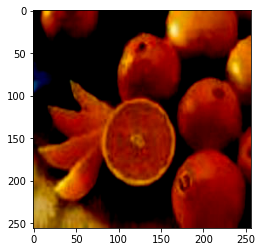

In [45]:
plt.imshow(real.cpu().numpy().transpose(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


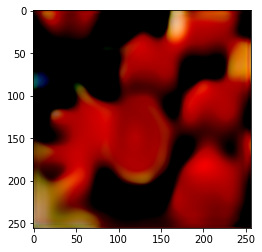

In [46]:
plt.imshow(np.squeeze(gen.detach().cpu().numpy().transpose(2,3,1,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


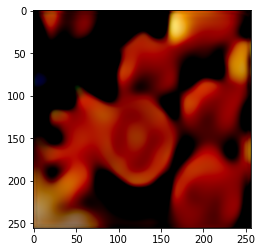

In [47]:
plt.imshow(np.squeeze(gen2.detach().cpu().numpy().transpose(2,3,1,0)))